In this notebook we will compare out of sample accuracy score for predicting positive returns to different forex instruments at the daily level.

In [1]:
# import libraries
import timeit
import warnings
warnings.filterwarnings("ignore")
#
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
#
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

To keep things simple, we use 6 Technical Indicators (with multiple parameters) and construct the target label as a 1-day return (Up or Down).

In [3]:
#Function to generate the dataset
def dataset(ticker, days):
    # Define time to download data
    today = datetime.today()
    initial = today - dt.timedelta(days=days)
    today = today.strftime('%Y-%m-%d')
    initial = initial.strftime('%Y-%m-%d')
    #Download data with YFINANCE
    data = yf.download(ticker, start=initial, end=today, progress=False)
    # list with parameter values to use with the Technical Indcators:
    periods = range(14,50)
    # dataframe creation with the Technical Indicators
    df = pd.DataFrame(data[['High', 'Low', 'Close']])
    for n in periods:
        #CCI - Commodity Channel Index
        df.ta.cci(length=n, append=True)
        #RSI - Relative Strength Index
        df.ta.rsi(length=n, append=True)
        #STOCH - Stochastic
        df.ta.stoch(k=n, append=True)
        #WILLR - Williams' %R
        df.ta.willr(length=n, append=True)
        #ADX
        df.ta.adx(length=n, append=True)
        #MACD - Moving Average Convergence/Divergence
        df.ta.macd(slow=n, append=True)
    df.index = data.index
    # 1-day return
    df["Return"] = df["Close"].pct_change().shift(-1)
    # Target variable label
    df["Label"] = np.where(df["Return"]>0,"UP","DOWN")
    # drop nan values
    df = df.dropna()
    df = df.drop(columns=['High', 'Low'])
    return df

# 2. Out-of-sample (OOS) & In-sample (IS) datasets

We assume that 1 year corresponds with 250 observations.

We keep the last year as an out of sample period (OOS) and we define multiple in sample periods (IS).

In this example we use EURUSD as an instrument, which suffer less from a bullish bias like other instruments that pertain to the stock market, for example.

In [4]:
instrument = "EURUSD=X"
data = dataset(instrument, 4000)
data

,Close,CCI_14_0.015,RSI_14,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,ADX_14,DMP_14,DMN_14,MACD_12_14_9,...,STOCHd_49_3_3,WILLR_49,ADX_49,DMP_49,DMN_49,MACD_12_49_9,MACDh_12_49_9,MACDs_12_49_9,Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-19,1.294498,-137.511729,39.491877,22.171553,22.283654,-77.469023,16.554333,19.535989,24.257263,-0.001587,...,8.200079,-92.284647,15.773348,22.182876,21.324187,-0.013954,-0.002995,-0.010960,-0.006265,DOWN
2013-03-20,1.286389,-154.600148,35.869941,8.603665,16.414500,-100.430334,16.370907,18.249691,24.187050,-0.001686,...,5.607499,-100.139949,15.296212,21.681624,21.366367,-0.015118,-0.003327,-0.011791,0.006044,UP
2013-03-21,1.294163,-90.318823,41.416998,16.848104,15.874441,-71.556331,16.200628,17.194403,22.788434,-0.001564,...,5.268649,-90.749849,14.839381,21.257209,20.948123,-0.015085,-0.002635,-0.012450,-0.002839,DOWN
2013-03-22,1.290489,-69.875010,39.670583,14.270387,13.240719,-85.202173,15.444453,18.912847,21.169886,-0.001518,...,4.399345,-95.187606,14.474038,21.739295,20.446496,-0.015383,-0.002347,-0.013037,0.009234,UP
2013-03-25,1.302406,-3.029111,47.415082,34.098667,21.739053,-40.945495,14.456553,19.508307,18.880949,-0.001209,...,7.112865,-80.794915,14.189032,21.839287,19.683865,-0.014174,-0.000910,-0.013264,-0.012717,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-06,1.054663,-41.862291,38.768411,21.219943,16.395841,-65.079502,33.629347,15.599312,23.146626,-0.001233,...,7.297157,-84.098700,9.713464,16.210911,21.640885,-0.016706,-0.001176,-0.015529,0.001976,UP
2023-10-09,1.056747,-19.838547,41.460701,32.668669,22.280762,-57.558250,32.618607,14.835157,22.012756,-0.001060,...,10.122339,-80.673844,9.807993,15.986249,21.340971,-0.015990,-0.000368,-0.015621,0.001079,UP
2023-10-10,1.057888,33.977956,42.938925,45.007051,32.965221,-42.341094,30.818230,17.883413,20.747231,-0.000888,...,14.449229,-78.800096,9.833202,16.821089,20.997496,-0.015180,0.000353,-0.015533,0.002450,UP


In [5]:
# OOS period
oos = data.tail(250)
#IS period, remove oos data
in_sample = data.drop(oos.index)
#1-year IS
is_1A = in_sample.tail(250)
#2-year IS
is_2A = in_sample.tail(500)
#3-year IS
is_3A = in_sample.tail(750)
#4-year IS
is_4A = in_sample.tail(1000)
#5-year IS
is_5A = in_sample.tail(1250)
#6-year IS
is_6A = in_sample.tail(1500)
#7-year IS
is_7A = in_sample.tail(1750)
#8-year IS
is_8A = in_sample.tail(2000)
#9-year IS
is_9A = in_sample.tail(2250)
#10-year IS
is_10A = in_sample.tail(2500)
#11-year IS
is_11A = in_sample.tail(2750)
#12-year IS
is_12A = in_sample.tail(3000)

Function to generate the OOS accuracy Score for all different models

In [6]:
def score(model_name, in_sample, years_is):
  if model_name == "Decision Tree":
    model = DecisionTreeClassifier()
  if model_name == "Bagging":
    model = ExtraTreesClassifier()
  if model_name == "Random Forest":
    model = RandomForestClassifier()
  if model_name == "AdaBoost":
    model = AdaBoostClassifier()
  if model_name == "GradientBoosting":
    model = GradientBoostingClassifier()
  if model_name == "XGBoost":
    model = XGBClassifier()
  le = LabelEncoder()
  #IS independent variables (features)
  X = in_sample.iloc[:,:-3]
  #IS dependent variable (target label)
  Y = in_sample["Label"]
  Y = le.fit_transform(Y)
  #OOS independent variables (features)
  X_oos = oos.iloc[:,:-3]
  #OOS dependent variable (target label)
  Y_oos = oos["Label"]  
  Y_oos = le.fit_transform(Y_oos)
  # store OOS score and timing of the training
  scores = []
  start = timeit.default_timer()
  for n in range(10):
    # training
    model.fit(X, Y)
    #OOS ACCURACY
    score = accuracy_score(Y_oos, model.predict(X_oos))
    scores.append(score)
  end = timeit.default_timer() - start
  print(f'Years In-Sample: {years_is[-1]}. Time (ss) for training of model {model_name}: {end}')
  # We return the average score after 10 training iterations
  return round(np.mean(scores),2)

Function to construct a results table for each model

In [7]:
def table_scores(model, in_samples):
  years_is = []
  accuracy = []
  for years, period in enumerate(in_samples):
    years_is.append(years+1)
    scores = score(model, period, years_is)
    accuracy.append(scores)
  df_scores = pd.DataFrame({"years in sample": years_is, "accuracy oos": accuracy})
  df_scores =df_scores.set_index("years in sample")
  return df_scores

Display results for each model

In [8]:
models = ["Decision Tree", "Bagging", "Random Forest", "AdaBoost", "GradientBoosting", "XGBoost"]
in_samples = [is_1A, is_2A, is_3A, is_4A, is_5A, is_6A, is_7A, is_8A, is_9A, is_10A, is_11A, is_12A]

In [9]:
dect = table_scores("Decision Tree", in_samples)

Years In-Sample: 1. Time (ss) for training of model Decision Tree: 1.6102789999567904
Years In-Sample: 2. Time (ss) for training of model Decision Tree: 4.33797210000921
Years In-Sample: 3. Time (ss) for training of model Decision Tree: 5.978012099978514
Years In-Sample: 4. Time (ss) for training of model Decision Tree: 9.276703899959102
Years In-Sample: 5. Time (ss) for training of model Decision Tree: 15.437789399991743
Years In-Sample: 6. Time (ss) for training of model Decision Tree: 18.344466500042472
Years In-Sample: 7. Time (ss) for training of model Decision Tree: 24.060574299946893
Years In-Sample: 8. Time (ss) for training of model Decision Tree: 27.67691169999307
Years In-Sample: 9. Time (ss) for training of model Decision Tree: 30.672882800048683
Years In-Sample: 10. Time (ss) for training of model Decision Tree: 33.97247590002371
Years In-Sample: 11. Time (ss) for training of model Decision Tree: 35.12434730003588
Years In-Sample: 12. Time (ss) for training of model Decisi

In [10]:
bagging = table_scores("Bagging", in_samples)

Years In-Sample: 1. Time (ss) for training of model Bagging: 2.9239826999837533
Years In-Sample: 2. Time (ss) for training of model Bagging: 4.76732980000088
Years In-Sample: 3. Time (ss) for training of model Bagging: 6.914920900017023
Years In-Sample: 4. Time (ss) for training of model Bagging: 8.844410000019707
Years In-Sample: 5. Time (ss) for training of model Bagging: 10.889852899999823
Years In-Sample: 6. Time (ss) for training of model Bagging: 12.698704699985683
Years In-Sample: 7. Time (ss) for training of model Bagging: 14.437357300019357
Years In-Sample: 8. Time (ss) for training of model Bagging: 16.36579630000051
Years In-Sample: 9. Time (ss) for training of model Bagging: 18.25351840001531
Years In-Sample: 10. Time (ss) for training of model Bagging: 20.8984388000099
Years In-Sample: 11. Time (ss) for training of model Bagging: 20.500659200013615
Years In-Sample: 12. Time (ss) for training of model Bagging: 20.1827811000403


In [11]:
rf = table_scores("Random Forest", in_samples)

Years In-Sample: 1. Time (ss) for training of model Random Forest: 9.159641099977307
Years In-Sample: 2. Time (ss) for training of model Random Forest: 19.80293319997145
Years In-Sample: 3. Time (ss) for training of model Random Forest: 32.57611039996846
Years In-Sample: 4. Time (ss) for training of model Random Forest: 47.607563800003845
Years In-Sample: 5. Time (ss) for training of model Random Forest: 64.24762680003187
Years In-Sample: 6. Time (ss) for training of model Random Forest: 80.55304369999794
Years In-Sample: 7. Time (ss) for training of model Random Forest: 99.76682590000564
Years In-Sample: 8. Time (ss) for training of model Random Forest: 113.72957690001931
Years In-Sample: 9. Time (ss) for training of model Random Forest: 130.7925606999779
Years In-Sample: 10. Time (ss) for training of model Random Forest: 145.3604031999712
Years In-Sample: 11. Time (ss) for training of model Random Forest: 145.458054799994
Years In-Sample: 12. Time (ss) for training of model Random Fo

In [12]:
ab = table_scores("AdaBoost", in_samples)

Years In-Sample: 1. Time (ss) for training of model AdaBoost: 19.892819400003646
Years In-Sample: 2. Time (ss) for training of model AdaBoost: 42.37030840001535
Years In-Sample: 3. Time (ss) for training of model AdaBoost: 60.899799899954814
Years In-Sample: 4. Time (ss) for training of model AdaBoost: 75.32625089999055
Years In-Sample: 5. Time (ss) for training of model AdaBoost: 101.83692129998235
Years In-Sample: 6. Time (ss) for training of model AdaBoost: 104.07554510002956
Years In-Sample: 7. Time (ss) for training of model AdaBoost: 132.55489750002744
Years In-Sample: 8. Time (ss) for training of model AdaBoost: 160.46589890000178
Years In-Sample: 9. Time (ss) for training of model AdaBoost: 164.26594630000181
Years In-Sample: 10. Time (ss) for training of model AdaBoost: 190.65950309997424
Years In-Sample: 11. Time (ss) for training of model AdaBoost: 149.77281910000602
Years In-Sample: 12. Time (ss) for training of model AdaBoost: 150.15546280000126


In [13]:
gb = table_scores("GradientBoosting", in_samples)

Years In-Sample: 1. Time (ss) for training of model GradientBoosting: 82.02844269998604
Years In-Sample: 2. Time (ss) for training of model GradientBoosting: 164.96245809999527
Years In-Sample: 3. Time (ss) for training of model GradientBoosting: 250.0724470000132
Years In-Sample: 4. Time (ss) for training of model GradientBoosting: 334.7505377000198
Years In-Sample: 5. Time (ss) for training of model GradientBoosting: 422.54698659997666
Years In-Sample: 6. Time (ss) for training of model GradientBoosting: 532.0389547999948
Years In-Sample: 7. Time (ss) for training of model GradientBoosting: 658.2996582999476
Years In-Sample: 8. Time (ss) for training of model GradientBoosting: 817.6036412999965
Years In-Sample: 9. Time (ss) for training of model GradientBoosting: 901.9861045999569
Years In-Sample: 10. Time (ss) for training of model GradientBoosting: 1022.0868612999911
Years In-Sample: 11. Time (ss) for training of model GradientBoosting: 898.5479746999918
Years In-Sample: 12. Time (

In [14]:
xgb = table_scores("XGBoost", in_samples)

Years In-Sample: 1. Time (ss) for training of model XGBoost: 17.036298999970313
Years In-Sample: 2. Time (ss) for training of model XGBoost: 29.59777930000564
Years In-Sample: 3. Time (ss) for training of model XGBoost: 46.849978999991436
Years In-Sample: 4. Time (ss) for training of model XGBoost: 52.39695570000913
Years In-Sample: 5. Time (ss) for training of model XGBoost: 45.674709299986716
Years In-Sample: 6. Time (ss) for training of model XGBoost: 57.418719200009946
Years In-Sample: 7. Time (ss) for training of model XGBoost: 56.755063999968115
Years In-Sample: 8. Time (ss) for training of model XGBoost: 66.73964620003244
Years In-Sample: 9. Time (ss) for training of model XGBoost: 62.22506590001285
Years In-Sample: 10. Time (ss) for training of model XGBoost: 65.02730369998608
Years In-Sample: 11. Time (ss) for training of model XGBoost: 66.55040519998875
Years In-Sample: 12. Time (ss) for training of model XGBoost: 68.18156330002239


Display results altogether

In [17]:
results = pd.DataFrame()
results.index = dect.index
results["Decision Tree"] = dect["accuracy oos"]
results["Bagging"] = bagging["accuracy oos"]
results["Random Forest"] = rf["accuracy oos"]
results["AdaBoost"] = ab["accuracy oos"]
results["GradientBoosting"] = gb["accuracy oos"]
results["XGBoost"] = xgb["accuracy oos"]
results

,Decision Tree,Bagging,Random Forest,AdaBoost,GradientBoosting,XGBoost
years in sample,,,,,,
1,0.60,0.53,0.54,0.56,0.56,0.57
2,0.54,0.60,0.60,0.59,0.63,0.61
3,0.58,0.61,0.61,0.62,0.64,0.62
4,0.52,0.60,0.61,0.61,0.65,0.67
5,0.56,0.62,0.63,0.62,0.66,0.68
6,0.57,0.62,0.62,0.64,0.69,0.63
7,0.58,0.64,0.65,0.60,0.64,0.66
8,0.64,0.65,0.65,0.66,0.65,0.69
9,0.58,0.64,0.64,0.64,0.67,0.66


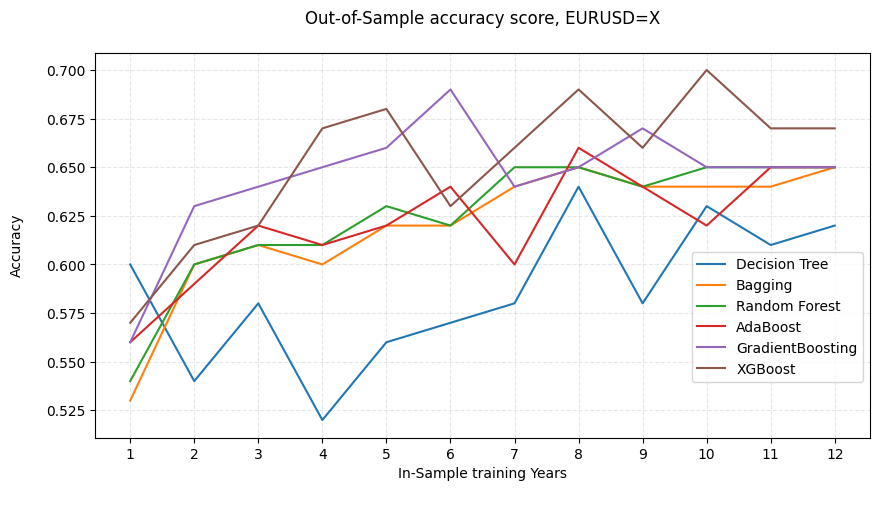

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(results["Decision Tree"], label="Decision Tree")
plt.plot(results["Bagging"], label="Bagging")
plt.plot(results["Random Forest"], label="Random Forest")
plt.plot(results["AdaBoost"], label="AdaBoost")
plt.plot(results["GradientBoosting"], label="GradientBoosting")
plt.plot(results["XGBoost"], label="XGBoost")
plt.legend(bbox_to_anchor = (1, 0.5))
plt.ylabel('Accuracy\n')
plt.xlabel('In-Sample training Years\n')
plt.title(f'Out-of-Sample accuracy score, {instrument}\n')
plt.xticks(np.arange(min(results.index), max(results.index)+1, 1.0))
plt.grid(True,linestyle='--',alpha=0.3)
plt.show()